In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import sys

plt.style.use('seaborn')
%matplotlib inline

up_df = pd.read_csv(r'Snapshot CSVs/Up_Snapshot.csv')
rim_df = pd.read_csv(r'Snapshot CSVs/Rim_Snapshot.csv')
fall_df = pd.read_csv(r'Snapshot CSVs/Fall_Snapshot.csv')

def dropAllDuplicates(df):
    duplicates = df.drop(['EVENT_NUM', 'SHOOTER_ID', 'SHOT_DISTANCE', 'SHOT_TIME',
                          'OFFENSIVE_REB', 'EVENT_TIME'], axis=1).duplicated(keep=False)
    return df[~duplicates]

def flipCourt(df):
    xlocs = [col for col in df.columns if ('XLOC' in col) and ('PLAYER' in col)]
    ylocs = [col for col in df.columns if ('YLOC' in col) and ('PLAYER' in col)]
    xvels = [col for col in df.columns if 'XVEL' in col]
    yvels = [col for col in df.columns if 'YVEL' in col]
    
    for i in range(0, len(xlocs)):
        df[xlocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df[xlocs[i]],
                                df[xlocs[i]])
        df[ylocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df[ylocs[i]],
                                df[ylocs[i]])
        df[xvels[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                -1 * df[xvels[i]],
                                df[xvels[i]])
        df[yvels[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                -1 * df[yvels[i]],
                                df[yvels[i]])
    df['BALL_DISTRIM'] = np.where(rim_df['BALL_XLOC'] > 47,
                                 df['BALL_DIST_RIM2'],
                                 df['BALL_DIST_RIM1'])
    df['BALL_YLOC'] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df['BALL_YLOC'],
                                df['BALL_YLOC'])
    df['BALL_XLOC'] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df['BALL_XLOC'],
                                df['BALL_XLOC'])
    
    return df

def distToRim(df):
    for i in range(1, 11):
        col = 'PLAYER{}_{}'
        xloc = df[col.format(i, 'XLOC')]
        yloc = df[col.format(i, 'YLOC')]
        df[col.format(i, 'DISTRIM')] = ((xloc-5.25)**2 + (yloc-25)**2)**.5
    return df

def distToBall(df):
    for i in range(1, 11):
        col = 'PLAYER{}_{}'
        xloc = df[col.format(i, 'XLOC')]
        yloc = df[col.format(i, 'YLOC')]
        bx = df['BALL_XLOC']
        by = df['BALL_YLOC']
        df[col.format(i, 'DISTBALL')] = ((xloc-bx)**2 + (yloc-by)**2)**.5
    return df

up_df = dropAllDuplicates(up_df)
rim_df = dropAllDuplicates(rim_df)
fall_df = dropAllDuplicates(fall_df)

up_df = flipCourt(up_df)
fall_df = flipCourt(fall_df)
rim_df = flipCourt(rim_df)

up_df = distToRim(up_df)
fall_df = distToRim(fall_df)
rim_df = distToRim(rim_df)

up_df = distToBall(up_df)
fall_df = distToBall(fall_df)
rim_df = distToBall(rim_df)

In [41]:
# Remove non-shots. These are plays that descend to 11 feet farther than 5 feet away
goodrows = ((rim_df['BALL_DIST_RIM1'] < 5) | (rim_df['BALL_DIST_RIM2'] < 5))

up_df = up_df[goodrows]
rim_df = rim_df[goodrows]
fall_df = fall_df[goodrows]

# Shots outside of 30 feet and rebounds over 20
badrows = ((up_df['BALL_DISTRIM'] > 30) | (fall_df['BALL_DISTRIM'] > 25))

up_df = up_df[~badrows]
rim_df = rim_df[~badrows]
fall_df = fall_df[~badrows]

In [42]:
teamlist = list(up_df['PLAYER1_TEAMID'].unique())

up_df = up_df[~up_df['REBOUNDER_ID'].isin(teamlist)]
rim_df = rim_df[~rim_df['REBOUNDER_ID'].isin(teamlist)]
fall_df = fall_df[~fall_df['REBOUNDER_ID'].isin(teamlist)]

In [43]:
xloc = 'PLAYER{}_{}'
yloc = 'PLAYER{}_{}'
for i in range(1,11):
    xshift = rim_df[xloc.format(i,'XLOC')] - 5.25
    yshift = rim_df[yloc.format(i,'YLOC')] - 25
    theta = np.arctan2(yshift, xshift)
    
    newx = xshift*np.cos(theta) + yshift*np.sin(theta)
    newy = -xshift*np.sin(theta) + yshift*np.cos(theta)
    
    velx = rim_df[xloc.format(i, 'XVEL')]
    vely = rim_df[xloc.format(i, 'YVEL')]
    
    rim_df[xloc.format(i, 'VELRIM')] = -velx*np.cos(theta) - vely*np.sin(theta)
    
    rim_df[xloc.format(i,'BOXEDOUT')] = False
    
    for j in range(1,11):
        if i != j:
            pxshift = rim_df[xloc.format(j,'XLOC')] - 5.25
            pyshift = rim_df[yloc.format(j,'YLOC')] - 25
            
            px = pxshift*np.cos(theta) + pyshift*np.sin(theta)
            py = -pxshift*np.sin(theta) + pyshift*np.cos(theta)
            
            rim_df[xloc.format(i,'BOXEDOUT')] = (rim_df[xloc.format(i,'BOXEDOUT')] |
                                                ((0 < newx - px) &
                                                (6 > newx - px) &
                                                (newx > newx - px) &
                                                (np.fabs(py) < np.fabs(px/2)) &
                                                (np.fabs(py) < 2)) &
                                                (np.fabs((newx-px)) > np.fabs(py)))

In [85]:
for i in range(1,11):
    rim_df[xloc.format(i, 'GOFORREB')] = ((rim_df[xloc.format(i, 'DISTRIM')] < 15) |
                                          ((rim_df[xloc.format(i, 'VELRIM')] > 3) &
                                           (rim_df[xloc.format(i, 'DISTRIM')] < 25)))

Rebounder: PLAYER7
PLAYER1_GOFORREB      True
PLAYER2_GOFORREB      True
PLAYER3_GOFORREB     False
PLAYER4_GOFORREB     False
PLAYER5_GOFORREB      True
PLAYER6_GOFORREB      True
PLAYER7_GOFORREB      True
PLAYER8_GOFORREB      True
PLAYER9_GOFORREB      True
PLAYER10_GOFORREB     True
Name: 261, dtype: object


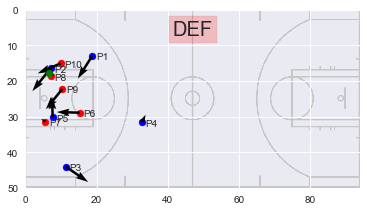

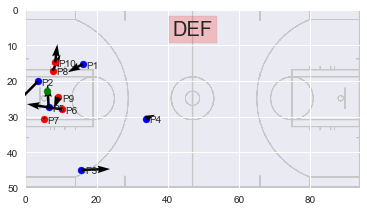

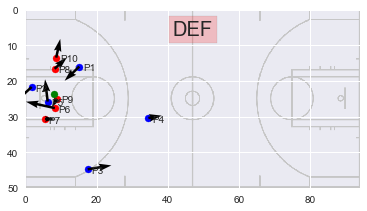

In [90]:
def plotPlay(df, i, suf):
    court = plt.imread("fullcourt.png")
    plt.imshow(court, zorder = 0, extent=[0,94,50,0])
    col = 'PLAYER{}_{}'
    row = df.iloc[i]
    ax = plt.gca()
    for j in range(1,11):
        x = col.format(j, 'XLOC')
        y = col.format(j, 'YLOC')
        xv = col.format(j, 'XVEL')
        yv = col.format(j, 'YVEL')
        if j <= 5:
            c = 'blue'
        else:
            c = 'red'
        plt.scatter(row[x], row[y], c = c)
        plt.text(row[x]+1, row[y]+1, 'P'+str(j))
        ax.quiver(row[x], row[y], row[xv], row[yv], angles = 'xy', scale_units='xy', scale = 1)

    plt.scatter(row['BALL_XLOC'], row['BALL_YLOC'], c = 'green')
#     plt.scatter(row['BALL_XLOC_FALL'], row['BALL_YLOC_FALL'], c = 'green')
    
#     plt.text(row['PLAYER1_XLOC'+suf], row['PLAYER1_YLOC'+suf], 'P1')
    
    if row['OFFENSIVE_REB'] == 1:
        txt = 'OFF'
        col = 'blue'
    else:
        txt = 'DEF'
        col = 'red'
    plt.text(47, 7, txt, fontsize=20, horizontalalignment='center',
             bbox=dict(facecolor=col, alpha=0.2))
    
    
n = 223

id_cols = [col for col in up_df.columns if '_ID' in col]
b = (up_df.iloc[n][id_cols] == up_df.iloc[n]['REBOUNDER_ID'])
print('Rebounder: {}'.format(b[b==True].index[0][:-3]))

# box_cols = [col for col in up_df.columns if 'BOXEDOUT' in col]
# print(up_df.iloc[n][box_cols])

reb_cols = [col for col in rim_df.columns if 'GOFORREB' in col]
print(rim_df.iloc[n][reb_cols])

plotPlay(up_df, n, '_FALL')
plt.show()
plotPlay(rim_df, n, '_FALL')
plt.show()
plotPlay(fall_df, n, '_FALL')
plt.show()

In [142]:
dist_cols = [col for col in test.columns if ('DISTRIM' in col) and ('PLAYER' in col)]
xloc_cols = [col for col in test.columns if ('XLOC' in col) and ('PLAYER' in col)]

col = 'PLAYER{}_{}'
for i in range(1, 11):
    vals = pd.Series((up_df[dist_cols].values < up_df[col.format(i, 'DISTRIM')].
                      values.reshape(len(up_df),1)).sum(axis=1))
    xvals = pd.Series((up_df[xloc_cols].values < up_df[col.format(i, 'XLOC')].
                      values.reshape(len(up_df),1)).sum(axis=1))
    up_df[col.format(i, 'DISTRANK')] = vals.values
    up_df[col.format(i, 'XRANK')] = xvals.values
